## Excess Credit Research

In [0]:
import pandas as pd
import pickle
import glob
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

### 1. Read Tables
- XPrograms
- tblAwards
- tblMergeX

In [2]:
# read table XPrograms
XPrograms = pd.read_excel("XPrograms.xlsx", index_col='ID').reset_index()
print(XPrograms.columns)
print(XPrograms.shape)
XPrograms.head(1)

Index(['ID', 'Maj', 'MajName', 'ProgName', 'Prog', 'Deg', 'Div', 'Dept', 'LYr',
       'FYr', 'ProgCredits', 'Bulletin Year', 'Banner Year', 'Extra'],
      dtype='object')
(3517, 14)


,ID,Maj,MajName,ProgName,Prog,Deg,Div,Dept,LYr,FYr,ProgCredits,Bulletin Year,Banner Year,Extra
0,3448,01A1,3+1 Graphic Design- EMU (X),3+1 Graphic Design- EMU (X),TR01A1,TR,BCT,DMAD,2015.0,2013.0,94.0,2013,2014,NaN


In [3]:
# read table tblAwards
tblAwards = pd.read_excel("tblAwards.xlsx", index_col=0)
print(tblAwards.columns)
print("Total Length of tblAwards: ", tblAwards.shape)
tblAwards.head(1)

Index(['CohortTrm', 'PIDM', 'WCCID', 'A/C', 'Cons/SO', 'TermsElpsd',
       'TermsAtt', 'CumCrAtt', 'CumCrErn', 'CumCrTran', 'CrAtt/Term',
       'CrErn/Term', 'SEX', 'Eth', 'EthComputed', 'Citz', 'BDate', 'Age',
       'GradAge', 'DegC', 'Maj', 'CIP', 'Prog', 'Div', 'ProgCredits',
       'CreditGrp', 'CtlgYr', 'DegDte', 'GradAcadYr', 'FirstDeg', 'Minor',
       'Conc', 'FTrmCrAtt', 'Seq'],
      dtype='object')
Total Length of tblAwards:  (54304, 34)


,CohortTrm,PIDM,WCCID,A/C,Cons/SO,TermsElpsd,TermsAtt,CumCrAtt,CumCrErn,CumCrTran,CrAtt/Term,CrErn/Term,SEX,Eth,EthComputed,Citz,BDate,Age,GradAge,DegC,Maj,CIP,Prog,Div,ProgCredits,CreditGrp,CtlgYr,DegDte,GradAcadYr,FirstDeg,Minor,Conc,FTrmCrAtt,Seq
DownloadDte,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-09,199509,1133,@00015315,A,SO,31.0,15.0,102.0,90.0,0.0,6.8,6.0,M,W,W,Y,1962-07-09,23.0,33.0,AGS,GST,240102.0,NaN,ATP,NaN,60-75,NaN,1995-12-16,1996.0,1,NaN,NaN,198509,11.10.10111.10.00.00.11.11.11.A


In [4]:
chunk_size = 40000 #size of chunks relies on your available memory
separator = ","

# read in the data as chunks and save each chunk as pickle
reader = pd.read_csv("./tblMergeX.csv",sep=separator,chunksize=chunk_size, low_memory=False)
i=1
for chunk in reader:
    out_file = "./" + "data_{}.pkl".format(i)
    with open(out_file, "wb") as f:
        pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
    i+=1

# read in the pickles and append each pickle to your desired dataframe
pickle_path = "./" #Same Path as out_path i.e. where the pickle files are
data_p_files=[]
for name in glob.glob(pickle_path + "/data_*.pkl"):
    data_p_files.append(name)

tblMergeX = pd.DataFrame([])
for i in range(len(data_p_files)):
    tblMergeX = tblMergeX.append(pd.read_pickle(data_p_files[i]),ignore_index=True)
print(tblMergeX.shape)
tblMergeX.head(5)

(391284, 42)


,DownloadDte,UA,PIDM,RegTerm,BDate,Age,SEX,Eth,FTrmCrAtt,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemHonPts,SemGPA,EDLV,EGOL,Maj,Prog,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumHonPts,CumGPA,CntTrmAtt,NextTrmAtt,NextYrAtt,PELL,SType,AdmtCd,AdmtTrm,Resid,ResdCd,RateCd,ALMT_MostRecent,ALRD_MostRecent,ALWR_MostRecent,ALMT_Initial,ALRD_Initial,ALWR_Initial,HSGPA
0,8/14/2019,0,797221,201105,6/27/1989,21.0,F,W,200709.0,1,6.0,6.0,6.0,21.0,3.500000,TCC,AT,HUST,AAHUST,98.0,98.0,15.0,98.0,367.6,3.751020,9.0,0.0,0.0,0,C,ST,200709.0,I,I,NaN,7.0,6.0,6.0,NaN,NaN,NaN,NaN
1,8/14/2019,0,797221,201201,6/27/1989,22.0,F,W,200709.0,1,7.0,7.0,7.0,28.0,4.000000,TCC,AT,HUST,AAHUST,104.0,104.0,15.0,104.0,388.6,3.736538,10.0,0.0,0.0,0,C,ST,200709.0,O,O,NaN,7.0,6.0,6.0,NaN,NaN,NaN,NaN
2,8/14/2019,0,797222,200909,3/26/1989,20.0,M,W,200709.0,1,9.0,9.0,9.0,21.9,2.433333,HSG,AT,BAS,AABAS,47.0,29.0,NaN,29.0,79.0,2.724138,5.0,1.0,0.0,0,C,ST,200709.0,I,I,NaN,6.0,6.0,6.0,NaN,NaN,NaN,NaN
3,8/14/2019,0,797222,201001,3/26/1989,20.0,M,W,200709.0,1,14.0,14.0,14.0,31.0,2.214286,HSG,AT,BAS,AABAS,56.0,38.0,NaN,38.0,100.9,2.655263,6.0,0.0,0.0,0,C,ST,200709.0,I,I,NaN,6.0,6.0,6.0,NaN,NaN,NaN,NaN
4,8/14/2019,0,797222,201705,3/26/1989,28.0,M,W,200709.0,1,6.0,6.0,6.0,24.0,4.000000,T4Y,TR,HLT,HLT,70.0,52.0,NaN,52.0,131.9,2.536538,7.0,0.0,1.0,0,R,ST,201705.0,O,O,NaN,6.0,6.0,6.0,NaN,NaN,NaN,NaN


### 2. Subset tblMergeX

In [5]:
# extract some race-major-course-credits info from tblMergeX to subset
tblMergeX.columns

Index(['DownloadDte', 'UA', 'PIDM', 'RegTerm', 'BDate', 'Age', 'SEX', 'Eth',
       'FTrmCrAtt', 'SecTrmAtt', 'SemCrAtt', 'SemCrErn', 'SemCrGPA',
       'SemHonPts', 'SemGPA', 'EDLV', 'EGOL', 'Maj', 'Prog', 'CumCrAtt',
       'CumCrErn', 'CumCrErnTrans', 'CumCrGPA', 'CumHonPts', 'CumGPA',
       'CntTrmAtt', 'NextTrmAtt', 'NextYrAtt', 'PELL', 'SType', 'AdmtCd',
       'AdmtTrm', 'Resid', 'ResdCd', 'RateCd', 'ALMT_MostRecent',
       'ALRD_MostRecent', 'ALWR_MostRecent', 'ALMT_Initial', 'ALRD_Initial',
       'ALWR_Initial', 'HSGPA'],
      dtype='object')

In [6]:
basicInfo = ['PIDM', 'Age', 'SEX', 'Eth']
majorInfo = ['Maj', 'Prog']

GPAInfo = ['SemGPA', 'CumGPA']
termInfo = ['RegTerm', 'FTrmCrAtt', 'CntTrmAtt']
creditInfo = ['CumCrAtt', 'CumCrErn', 'CumCrErnTrans']

TotalInfo = basicInfo + majorInfo + GPAInfo + termInfo + creditInfo
# sub_tblMergeX - contain all needed info at this point
sub_tblMergeX = tblMergeX[TotalInfo]
print(sub_tblMergeX.shape)
sub_tblMergeX.head(5)

(391284, 14)


,PIDM,Age,SEX,Eth,Maj,Prog,SemGPA,CumGPA,RegTerm,FTrmCrAtt,CntTrmAtt,CumCrAtt,CumCrErn,CumCrErnTrans
0,797221,21.0,F,W,HUST,AAHUST,3.500000,3.751020,201105,200709.0,9.0,98.0,98.0,15.0
1,797221,22.0,F,W,HUST,AAHUST,4.000000,3.736538,201201,200709.0,10.0,104.0,104.0,15.0
2,797222,20.0,M,W,BAS,AABAS,2.433333,2.724138,200909,200709.0,5.0,47.0,29.0,NaN
3,797222,20.0,M,W,BAS,AABAS,2.214286,2.655263,201001,200709.0,6.0,56.0,38.0,NaN
4,797222,28.0,M,W,HLT,HLT,4.000000,2.536538,201705,200709.0,7.0,70.0,52.0,NaN


### 3. Subset tblAwards

In [7]:
# extract some race-major-course-credits info from tblAwards to subset
basicInfo_aw = ['PIDM', 'WCCID', 'A/C', 'Age', 'GradAge', 'SEX', 'Eth']
# CohortTrm - final quit
termInfo_aw = ['CohortTrm', 'FTrmCrAtt', 'TermsElpsd', 'TermsAtt', 'GradAcadYr']
majorInfo_aw = ['Maj', 'Prog', 'DegC']
creditInfo_aw = ['CumCrAtt', 'CumCrErn', 'CumCrTran', 'ProgCredits']

TotalInfo_aw = basicInfo_aw + termInfo_aw + majorInfo_aw + creditInfo_aw
sub_tblAwards = tblAwards[TotalInfo_aw].reset_index()
print(sub_tblAwards.shape)
sub_tblAwards.head(5)

(54304, 20)


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits
0,2019-09-09,1133,@00015315,A,23.0,33.0,M,W,199509,198509,31.0,15.0,1996.0,GST,NaN,AGS,102.0,90.0,0.0,NaN
1,2019-09-09,1318,@00015500,A,20.0,26.0,M,W,199509,199005,17.0,10.0,1996.0,CEMP,NaN,AS,98.0,77.0,0.0,NaN
2,2019-09-09,1322,@00015504,A,18.0,20.0,M,W,199509,199305,8.0,7.0,1996.0,ROB,NaN,ATS,67.0,67.0,0.0,NaN
3,2019-09-09,1458,@00015640,A,17.0,21.0,F,W,199509,199209,10.0,8.0,1996.0,ROB,NaN,ATS,80.0,75.0,0.0,NaN
4,2019-09-09,1507,@00015689,A,27.0,49.0,M,W,199509,197309,67.0,22.0,1996.0,NURS,NaN,AAS,158.0,119.0,5.0,NaN


In [8]:

sub_tblAwards = sub_tblAwards[(sub_tblAwards['FTrmCrAtt'] >=200909) & 
                              (sub_tblAwards['CohortTrm'] <=201905)]
print(sub_tblAwards.shape)

(21102, 20)


### 4. Missing data imputation for subset tblAwards 

### 4.1 GPA Statistics

In [9]:
# find unique number of PIDM in tblMergeX
print(len(sub_tblMergeX['PIDM'].unique()))

# chek if MergeX table contains all appears in Awards
A = list(sub_tblMergeX['PIDM'].unique())
B = list(sub_tblAwards['PIDM'].unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# filter out all certificate and check again
B = list(sub_tblAwards[sub_tblAwards['A/C'] == "A"].PIDM.unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# filter out all graduates before year 2000 and check again
B = list(sub_tblAwards[(sub_tblAwards['A/C'] == "A") & 
                       (sub_tblAwards['GradAcadYr'] >= 2000)].PIDM.unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# find unique records in tbl_Awards somehow
sub_tblAwards[sub_tblAwards["PIDM"].isin(list(set(B).difference(set(A))))].head(5)

111789
Number of unique PIDM in table Awards:  2
Number of unique PIDM in table Awards:  1
Number of unique PIDM in table Awards:  1


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits
23332,2019-09-09,627310,@00281511,A,NaN,50.0,M,X,201009,999999,NaN,NaN,2011.0,ITRN,APITRN,AAS,NaN,NaN,63.5,60.0


In [10]:
# find number of common PIDM in subset tblAwards and tblMergeX
temp = pd.merge(sub_tblAwards, sub_tblMergeX, how='inner', on=['PIDM'])
print("Number of Awarded students whose GPA is available: ", len(temp['PIDM'].unique()))
print("Percent: ", len(temp['PIDM'].unique())/sub_tblAwards.shape[0])

Number of Awarded students whose GPA is available:  12859
Percent:  0.6093735190977159


### 4.2 Major/Programs required credits imputation

In [11]:
sub_tblAwards = pd.merge(sub_tblAwards, XPrograms[['Maj', 'Bulletin Year', 'ProgCredits']], how='left',
                         left_on=['Maj', 'GradAcadYr'], right_on=['Maj', 'Bulletin Year'])
# set new column for credits earned from WCC
sub_tblAwards['CumCrEarnedWCC'] = sub_tblAwards['CumCrErn'] - sub_tblAwards['CumCrTran']

print(sub_tblAwards.shape)
sub_tblAwards.head(5)

(21102, 23)


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,ProgCredits_y,CumCrEarnedWCC
0,2019-09-09,33654,@00047286,C,51.0,51.0,F,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,62.0,58.0,4.0,2010.0,4.0,4.0
1,2019-09-09,137385,@00149495,C,54.0,54.0,M,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,4.0,0.0,4.0,2010.0,4.0,4.0
2,2019-09-09,176053,@00187849,C,38.0,38.0,M,A,200909,200909,1.0,1.0,2010.0,PA,CTPA,CER,16.0,16.0,0.0,16.0,2010.0,16.0,16.0
3,2019-09-09,572964,@00010471,C,58.0,58.0,F,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,4.0,0.0,4.0,2010.0,4.0,4.0
4,2019-09-09,601793,@00264849,C,50.0,50.0,M,W,200909,200909,1.0,1.0,2010.0,PA,CTPA,CER,16.0,16.0,0.0,16.0,2010.0,16.0,16.0


In [12]:
# Combine ProgCredits columns from two tables
sub_tblAwards['ProgCredits_x'].fillna(sub_tblAwards['ProgCredits_y'], inplace=True)
del sub_tblAwards['ProgCredits_y']
sub_tblAwards.head(5)

,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC
0,2019-09-09,33654,@00047286,C,51.0,51.0,F,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,62.0,58.0,4.0,2010.0,4.0
1,2019-09-09,137385,@00149495,C,54.0,54.0,M,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,4.0,0.0,4.0,2010.0,4.0
2,2019-09-09,176053,@00187849,C,38.0,38.0,M,A,200909,200909,1.0,1.0,2010.0,PA,CTPA,CER,16.0,16.0,0.0,16.0,2010.0,16.0
3,2019-09-09,572964,@00010471,C,58.0,58.0,F,W,200909,200909,1.0,1.0,2010.0,NAST,CCNAST,CCM,4.0,4.0,0.0,4.0,2010.0,4.0
4,2019-09-09,601793,@00264849,C,50.0,50.0,M,W,200909,200909,1.0,1.0,2010.0,PA,CTPA,CER,16.0,16.0,0.0,16.0,2010.0,16.0


### 4.3 Split sub_tblAwards based on duplicated PIDM

In [13]:
# filter out year before 2000 and all certificate degree 
sub_tblAwards = sub_tblAwards[(sub_tblAwards['A/C'] == "A")]
print(sub_tblAwards.shape)
print(len(sub_tblAwards['PIDM'].unique()))

# play with excess credits
sub_tblAwards['ExcessCr'] = sub_tblAwards['CumCrErn'] - sub_tblAwards['ProgCredits_x']
print(sub_tblAwards[sub_tblAwards['ExcessCr'] < 0].shape)
print("Negative percent: ", sub_tblAwards[sub_tblAwards['ExcessCr'] < 0].shape[0]/sub_tblAwards.shape[0])
print(sub_tblAwards['ExcessCr'].describe())

# at this point - only work on those non-negative credits records
sub_tblAwards = sub_tblAwards[sub_tblAwards['ExcessCr'] >= 0]
print(len(sub_tblAwards['PIDM'].unique()))

(6953, 22)
6364
(112, 23)
Negative percent:  0.01610815475334388
count    6923.000000
mean       17.917016
std        15.139833
min       -44.000000
25%         7.000000
50%        15.000000
75%        26.000000
max       132.000000
Name: ExcessCr, dtype: float64
6229


### 5. Statistics and Plotting

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np

### 5.1 No Transfer credits - ALL from WCC

In [16]:
# filter those who has no transfer credits
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] == 0]
print(sub_tblAwards.shape)
print("Shape of records having no transfer credits: ", temp.shape)

(6811, 23)
Shape of records having no transfer credits:  (4089, 23)


### 5.1.1 Only one Associate degree

In [17]:
# split sub_tblAwards into two tables based on the duplicity of records
temp_sig = temp.drop_duplicates('PIDM', keep=False)
print(len(temp_sig['PIDM'].unique()))

3294


#### Enrolled Term and Elapsed Term for Associate Degree

      TermsAtt  TermsElpsd
DegC                      
AA        1651        1651
AAS       1092        1092
AS         551         551


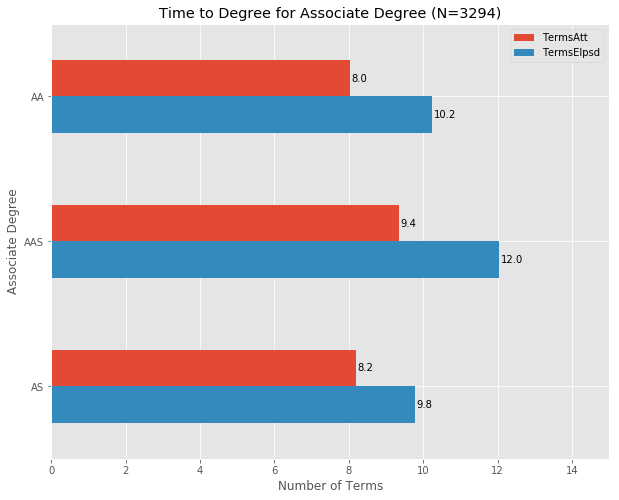

In [21]:
df = temp_sig[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").count())

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree for Associate Degree (N=3294)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.savefig("A.1.1.1.png", dpi=250)
plt.show()

(2092, 3)


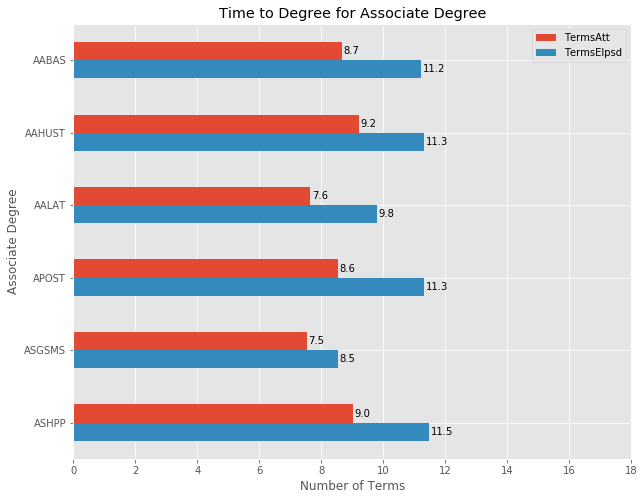

In [22]:
count_test = temp_sig[["TermsAtt", "TermsElpsd", "Prog"]].groupby('Prog').filter(lambda x: len(x) > 100)
df = count_test[["TermsAtt", "TermsElpsd", "Prog"]].groupby("Prog").mean()
print(count_test.shape)

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 18) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree for Associate Degree")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.savefig("A.1.1.2.png", dpi=800)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F        1793        1793
    M        1501        1501


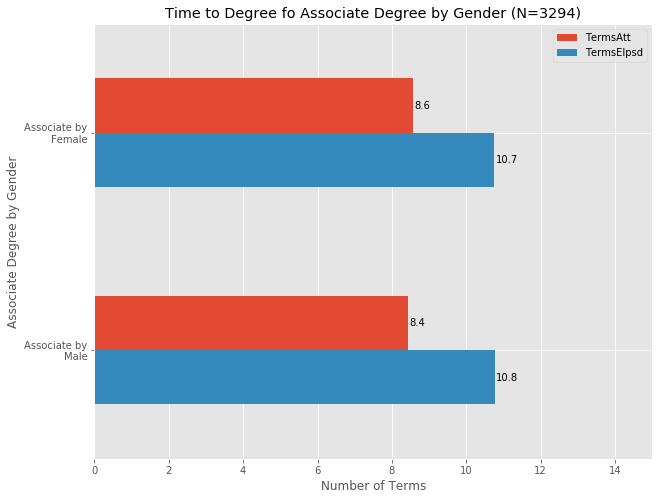

In [20]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender (N=3294)")
ax.set_yticklabels(["Associate by\nFemale", "Associate by\nMale"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.rcParams["figure.figsize"] = (10,8)
plt.savefig("A.1.1.3.png", dpi=800, bbox="tight")
plt.show()

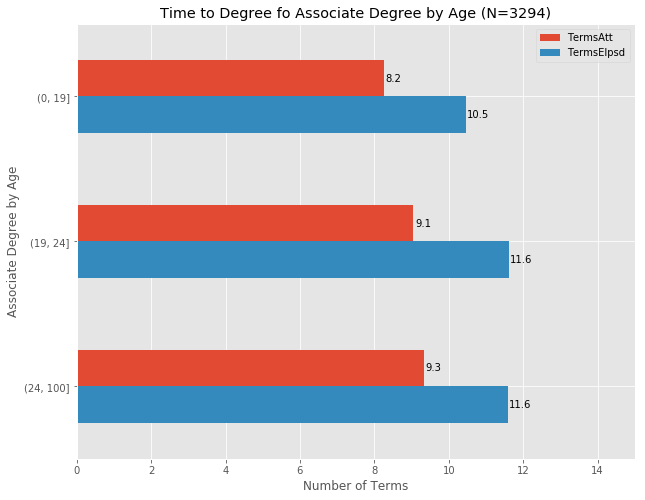

In [23]:
bins = [0, 19, 24, 100]
df = temp_sig[["TermsAtt", "TermsElpsd"]].groupby(pd.cut(temp_sig["Age"], bins=bins))

# df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean()
# print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean())

ax = df.mean().plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Age")
ax.set_title("Time to Degree fo Associate Degree by Age (N=3294)")
# ax.set_yticklabels(["Associate\nAge<=20", "Associate\nAge>20"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)    
plt.savefig("A.1.1.4.png", dpi=800, bbox="tight")
plt.show()


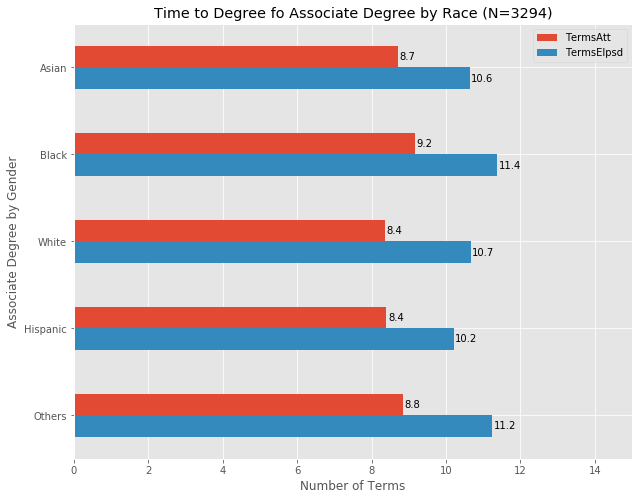

In [24]:
race_list = ['A', 'B', 'W', 'H']
temp_sig.loc[~temp_sig["Eth"].isin(race_list), "Eth"] = "Others" 
df = temp_sig[["TermsAtt", "TermsElpsd", "Eth"]].groupby(["Eth"]).mean().reset_index()

ax = df.set_index(['Eth']).reindex(['A', 'B', 'W', 'H', 'Others']).plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Race (N=3294)")
ax.set_yticklabels(["Asian", "Black", "White", "Hispanic", "Others"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.rcParams["figure.figsize"] = (10,8)
plt.savefig("A.1.1.5.png", dpi=800, bbox="tight")
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      6.894844
(10, 15]     9.883553
(15, 20]    12.020115
(20, 30]    13.435065


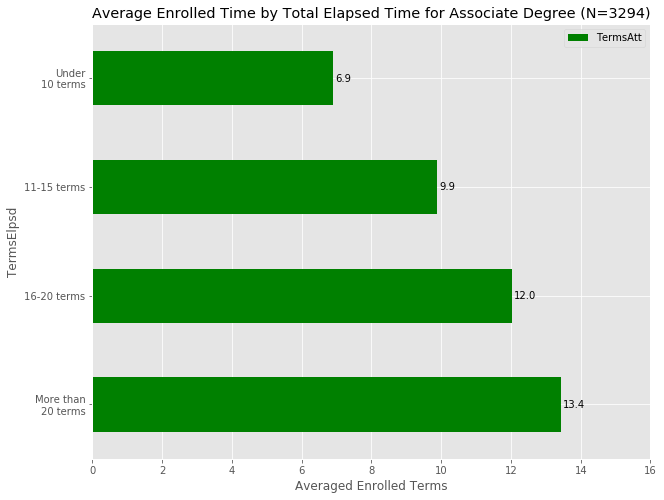

In [25]:
bins = [0, 10, 15, 20, 30]
df = temp_sig[["TermsAtt"]].groupby(pd.cut(temp_sig["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 16)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree (N=3294)")
# ytick
ax.set_yticklabels(["Under\n10 terms", "11-15 terms", "16-20 terms", "More than\n20 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.savefig("A.1.1.6.png", dpi=800, bbox="tight")
plt.show()


#### Statistical Table for Excess Credits

In [26]:
Counter(temp_sig.DegC)

Counter({'AA': 1651, 'AAS': 1092, 'AS': 551})

In [27]:
df = temp_sig.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
13,AALAT,60.0,878
45,APOST,60.0,339
0,AABAS,60.0,328
60,ASGSMS,60.0,309
61,ASHPP,60.0,137


In [28]:
temp_sig = temp_sig[(~temp_sig["Prog"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["Prog"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["Prog"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog"], right_on = ["Prog"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(12)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
13,AALAT,878,795,90.55%
45,APOST,339,324,95.58%
0,AABAS,328,305,92.99%
60,ASGSMS,309,305,98.71%
61,ASHPP,137,125,91.24%
10,AAHUST,101,101,100.00%
2,AACJ,93,92,98.92%
43,APNURS,90,90,100.00%
15,AASECO,73,70,95.89%
6,AAELEM,68,64,94.12%


In [29]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["Prog", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,60.0,72.00,74.879573,141.0,12.0,14.879573,81.0
1,AABCA,61.0,75.00,75.409091,90.5,14.0,13.590909,29.5
2,AACJ,63.0,84.00,85.376344,120.0,21.0,22.569892,57.0
3,AACMG,66.0,81.50,83.250000,98.5,15.5,18.250000,32.5
4,AADVP,62.0,72.75,75.033333,89.0,11.0,13.566667,29.0


In [30]:
composed = df.sort_values(by=['# Completers'], ascending=False).head(6)
plot_program_list = list(composed["Prog"])
print(plot_program_list)

['AALAT', 'APOST', 'AABAS', 'ASGSMS', 'ASHPP', 'AAHUST']


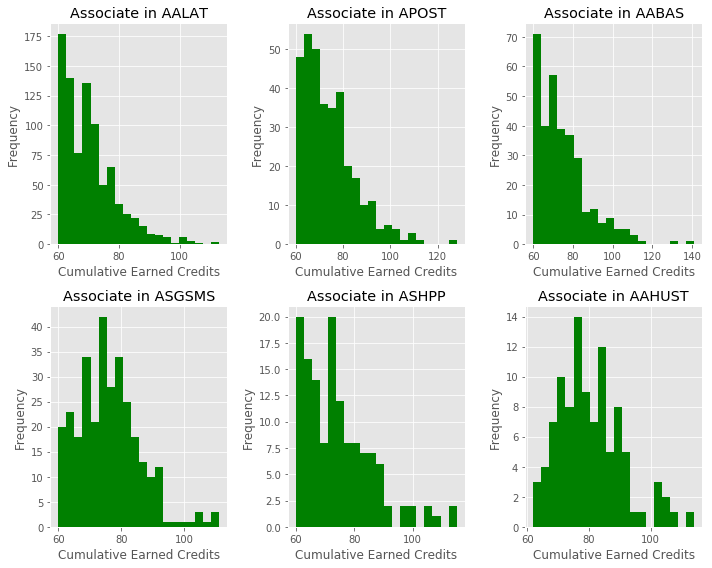

In [31]:
index = 0

fig, ax = plt.subplots(2, 3)
for irow in range(2):
  for jcol in range(3):
    ax[irow][jcol].hist(temp_sig[temp_sig['Prog'] == plot_program_list[index]].CumCrErn, color='green', bins=20)
    ax[irow][jcol].set_xlabel("Cumulative Earned Credits")
    ax[irow][jcol].set_ylabel("Frequency")
    ax[irow][jcol].set_title("Associate in " + plot_program_list[index])
    index = index + 1
plt.tight_layout()

plt.savefig("A.1.1.7.png", dpi=800, bbox="tight")

In [32]:
!pip install docx

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for docx: filename=docx-0.2.4-cp36-none-any.whl size=53926 sha256=2bb3290667b9532bfe9c074481896ff394c8b26ee327afc33058e12913e30e68
  Stored in directory: /root/.cache/pip/wheels/cc/8d/09/563edfd874a35c0c7ed129b6c4fa890efa4c26458bdec6ffc1
Successfully built docx


In [33]:
!pip install python-docx 

     |████████████████████████████████| 5.5MB 2.7MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=e3df2d67b73a0ccd5e6fd66c3837ac48178758d4ef26a7fc9c2657a9eb02c936
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


In [0]:
def doctable(data, tabletitle, pathfile):
    from docx import Document
    import pandas as pd
    document = Document()
    data = pd.DataFrame(data)  # My input data is in the 2D list form
    document.add_heading(tabletitle)
    table = document.add_table(rows=(data.shape[0]), cols=data.shape[1])  # First row are table headers!
    for i, column in enumerate(data) :
        for row in range(data.shape[0]) :
            table.cell(row, i).text = str(data[column][row])
    document.save(pathfile)

In [35]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog"], right_on = ["Prog"])
record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
13,AALAT,878,795,90.55%,60.0,68.00,70.226082,113.0,8.0,10.226082,53.0
45,APOST,339,324,95.58%,60.0,72.00,73.936578,128.0,12.0,13.936578,68.0
0,AABAS,328,305,92.99%,60.0,72.00,74.879573,141.0,12.0,14.879573,81.0
60,ASGSMS,309,305,98.71%,60.0,75.00,76.024272,111.0,15.0,16.024272,51.0
61,ASHPP,137,125,91.24%,60.0,73.00,74.416058,115.0,13.0,14.416058,55.0
10,AAHUST,101,101,100.00%,61.0,79.00,80.475248,114.0,18.0,19.485149,53.0
2,AACJ,93,92,98.92%,63.0,84.00,85.376344,120.0,21.0,22.569892,57.0
43,APNURS,90,90,100.00%,72.0,100.75,100.466667,124.5,32.5,31.511111,60.0
15,AASECO,73,70,95.89%,60.0,69.00,72.027397,101.0,9.0,12.027397,41.0
6,AAELEM,68,64,94.12%,63.0,74.00,74.522059,106.0,11.0,11.860294,43.0


In [0]:
record.to_excel("A.1.2.xlsx")

In [37]:
# Another table based on DegC
df = temp_sig.groupby(["DegC", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['DegC']).aggregate(aggregation_functions)

df = df.rename(columns={"DegC": "Degree", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,DegC,Required Credits,Num of Completers
0,AA,63.000000,1651
1,AAS,59.705882,1092
2,AS,64.500000,551


In [38]:
temp_sig = temp_sig[(~temp_sig["DegC"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["DegC"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["DegC"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["DegC"], right_on = ["DegC"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
0,AA,1651,1534,92.91%
1,AAS,1092,1060,97.07%
2,AS,551,535,97.10%


In [39]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["DegC", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["DegC", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['DegC']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,DegC,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AA,60.0,71.00,73.228649,141.0,10.0,12.798607,81.0
1,AAS,61.0,77.75,80.806319,142.0,15.0,18.140568,78.0
2,AS,60.0,76.00,77.225953,143.5,15.0,16.670599,83.0


In [40]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["DegC"], right_on = ["DegC"])
record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AA,1651,1534,92.91%,60.0,71.00,73.228649,141.0,10.0,12.798607,81.0
1,AAS,1092,1060,97.07%,61.0,77.75,80.806319,142.0,15.0,18.140568,78.0
2,AS,551,535,97.10%,60.0,76.00,77.225953,143.5,15.0,16.670599,83.0


In [0]:
record.to_excel("A.1.2(Degree).xlsx")

### 5.1.2 More than one Associate degree

In [42]:
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] == 0]
temp_dup = temp[temp.duplicated(['PIDM'], keep=False)]
print(len(temp_dup['PIDM'].unique()))

temp_dup.head(10)

389


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC,ExcessCr
1051,2019-09-09,841432,@00499908,A,18.0,19.0,M,W,201105,200909,6.0,5.0,2011.0,BAS,AABAS,AA,74.0,67.0,0.0,60.0,2011.0,67.0,7.0
1266,2019-09-09,673924,@00319541,A,33.0,35.0,M,W,201109,200909,7.0,7.0,2012.0,LAT,AALAT,AA,78.5,69.0,0.0,60.0,2012.0,69.0,9.0
1315,2019-09-09,828370,@00487111,A,52.0,54.0,F,W,201109,200909,7.0,7.0,2012.0,AATD,APAATD,AAS,74.0,74.0,0.0,64.0,2012.0,74.0,10.0
1404,2019-09-09,842791,@00501192,A,42.0,44.0,M,W,201109,200909,7.0,7.0,2012.0,CNTM,APCNTM,AAS,109.0,97.0,0.0,61.0,2012.0,97.0,36.0
1405,2019-09-09,842791,@00501192,A,42.0,44.0,M,W,201109,200909,7.0,7.0,2012.0,CSS,APCSS,AAS,109.0,97.0,0.0,63.0,2012.0,97.0,34.0
1450,2019-09-09,847222,@00505554,A,27.0,30.0,M,W,201109,200909,7.0,7.0,2012.0,OST,APOST,AAS,81.5,73.5,0.0,60.0,2012.0,73.5,13.5
1662,2019-09-09,795561,@00455335,A,17.0,19.0,F,I,201201,201005,6.0,6.0,2012.0,LAT,AALAT,AA,61.0,61.0,0.0,60.0,2012.0,61.0,1.0
1784,2019-09-09,839544,@00498049,A,18.0,21.0,M,B,201201,200909,8.0,8.0,2012.0,CNTM,APCNTM,AAS,95.0,92.0,0.0,60.0,2012.0,92.0,32.0
1806,2019-09-09,841317,@00499798,A,19.0,21.0,M,B,201201,200909,8.0,6.0,2012.0,LAT,AALAT,AA,76.5,76.5,0.0,60.0,2012.0,76.5,16.5
1839,2019-09-09,843289,@00501673,A,18.0,20.0,M,W,201201,200909,8.0,6.0,2012.0,LAT,AALAT,AA,69.5,69.5,0.0,60.0,2012.0,69.5,9.5


#### Enrolled Term and Elapsed Term for Associate Degree

      TermsAtt  TermsElpsd
DegC                      
AA         322         322
AAS        300         300
AS         173         173


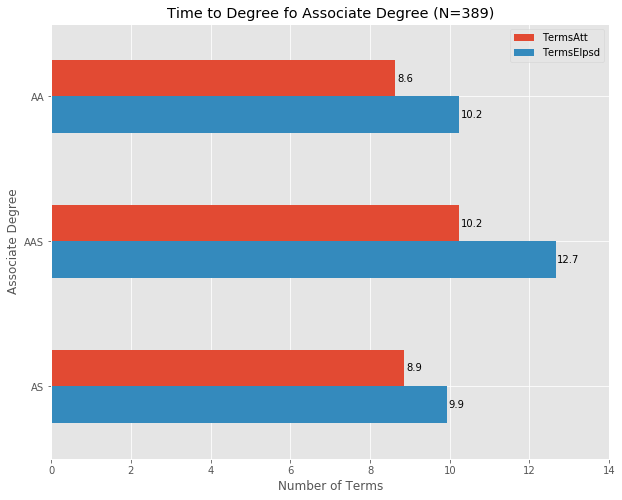

In [43]:
df = temp_dup[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").count())

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate Degree (N=389)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.savefig("A.2.1.1.png", dpi=800)
plt.show()

(4, 2)


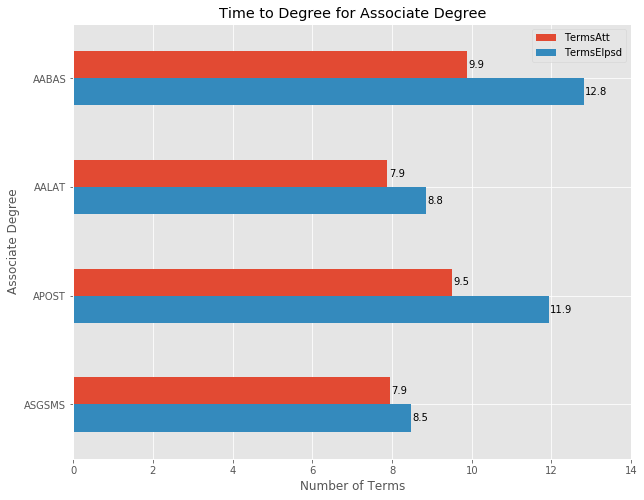

In [44]:
count_test = temp_dup[["TermsAtt", "TermsElpsd", "Prog"]].groupby('Prog').filter(lambda x: len(x) > 50)
df = count_test[["TermsAtt", "TermsElpsd", "Prog"]].groupby("Prog").mean()
print(df.shape)

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree for Associate Degree")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.savefig("A.2.1.2.png", dpi=800)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F         463         463
    M         332         332


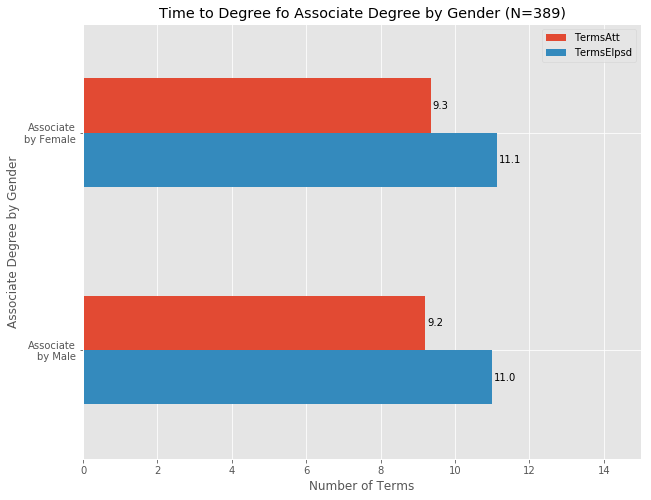

In [45]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender (N=389)")
ax.set_yticklabels(["Associate\nby Female", "Associate\nby Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)   
plt.savefig("A.2.1.3.png", dpi=800, bbox="tight")
plt.show()

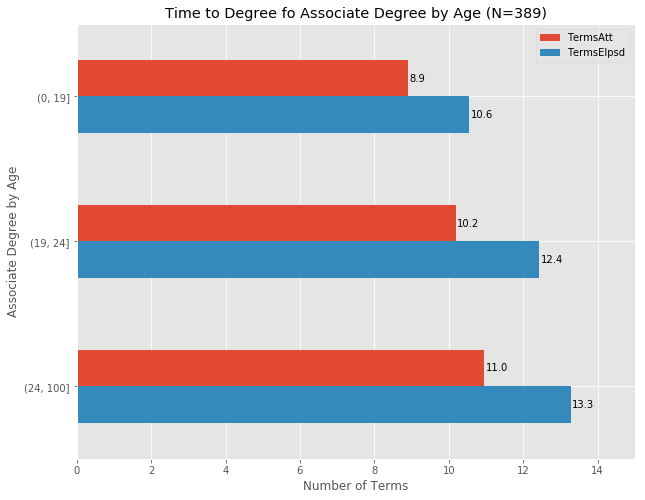

In [48]:
bins = [0, 19, 24, 100]
df = temp_dup[["TermsAtt", "TermsElpsd"]].groupby(pd.cut(temp_dup["Age"], bins=bins))

# df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean()
# print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean())

ax = df.mean().plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Age")
ax.set_title("Time to Degree fo Associate Degree by Age (N=389)")
# ax.set_yticklabels(["Associate\nAge<=20", "Associate\nAge>20"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)    
plt.savefig("A.2.1.4.png", dpi=800, bbox="tight")
plt.show()

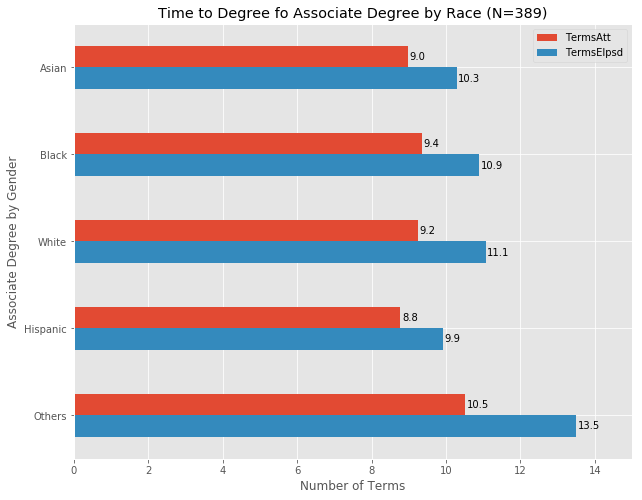

In [50]:
race_list = ['A', 'B', 'W', 'H']
temp_dup.loc[~temp_dup["Eth"].isin(race_list), "Eth"] = "Others" 
df = temp_dup[["TermsAtt", "TermsElpsd", "Eth"]].groupby(["Eth"]).mean().reset_index()

ax = df.set_index(['Eth']).reindex(['A', 'B', 'W', 'H', 'Others']).plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Race (N=389)")
ax.set_yticklabels(["Asian", "Black", "White", "Hispanic", "Others"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.rcParams["figure.figsize"] = (10,8)
plt.savefig("A.2.1.5.png", dpi=800, bbox="tight")
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      7.568376
(10, 15]    10.446154
(15, 20]    12.659091
(20, 30]    15.681818


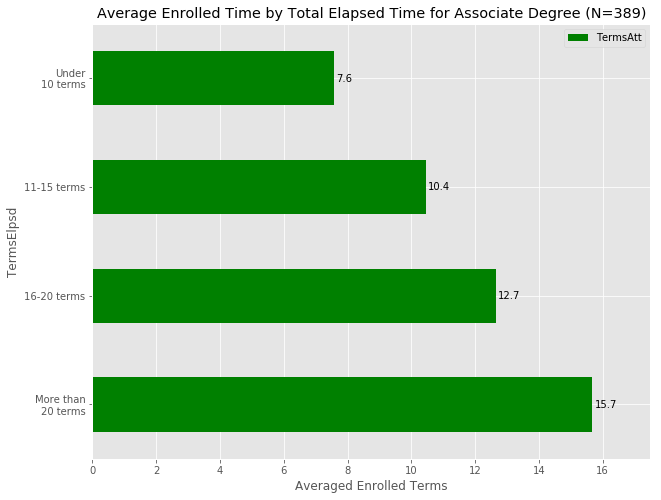

In [52]:
bins = [0, 10, 15, 20, 30]
df = temp_dup[["TermsAtt"]].groupby(pd.cut(temp_dup["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 17.5)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree (N=389)")
# ytick
ax.set_yticklabels(["Under\n10 terms", "11-15 terms", "16-20 terms", "More than\n20 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)
plt.savefig("A.2.1.6.png", dpi=800, bbox="tight")
plt.show()

#### Statistical Table for Excess Credits

In [53]:
df = temp_dup.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
12,AALAT,60.0,182
40,APOST,60.0,139
55,ASGSMS,60.0,106
0,AABAS,60.0,62
56,ASHPP,60.0,40


In [54]:
temp_dup = temp_dup[(~temp_dup["Prog"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["Prog"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["Prog"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog"], right_on = ["Prog"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
12,AALAT,182,177,97.25%
40,APOST,139,138,99.28%
55,ASGSMS,106,106,100.00%
0,AABAS,62,61,98.39%
56,ASHPP,40,40,100.00%


In [55]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["Prog", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,60.0,89.00,90.379032,142.0,29.00,30.379032,82.0
1,AABCA,61.0,79.00,77.500000,84.5,15.00,15.500000,23.5
2,AACJ,63.0,90.25,91.593750,113.0,28.25,29.718750,53.0
3,AACMG,66.0,105.00,109.500000,160.0,36.00,44.100000,100.0
4,AADVP,62.0,89.00,88.142857,109.0,27.00,26.714286,47.0


In [57]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog"], right_on = ["Prog"])
# excessCredits_table['Percent of Prior Credits'] = excessCredits_table['ExcessCr_mean']/excessCredits_table['CumCrErn_mean']
# excessCredits_table['Percent of Prior Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in excessCredits_table['Percent of Prior Credits']], index = excessCredits_table.index)

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
12,AALAT,182,177,97.25%,60.0,82.00,81.206044,128.0,22.00,21.206044,68.0
40,APOST,139,138,99.28%,60.0,88.00,89.697842,133.0,28.00,29.697842,73.0
55,ASGSMS,106,106,100.00%,60.0,83.00,83.990566,110.0,23.00,23.990566,50.0
0,AABAS,62,61,98.39%,60.0,89.00,90.379032,142.0,29.00,30.379032,82.0
56,ASHPP,40,40,100.00%,60.0,84.00,86.575000,147.0,24.00,26.575000,87.0
2,AACJ,16,16,100.00%,63.0,90.25,91.593750,113.0,28.25,29.718750,53.0
19,APANIM,13,13,100.00%,63.0,85.00,90.384615,128.0,22.00,27.538462,66.0
50,APWLDT,12,12,100.00%,66.0,89.00,98.625000,143.0,23.50,32.875000,77.0
39,APNURS,12,12,100.00%,65.5,120.00,125.083333,145.0,57.25,59.250000,77.0
38,APNURE,11,11,100.00%,71.0,109.00,116.000000,147.0,33.00,42.818182,76.0


In [0]:
record.to_excel("A.2.2.xlsx")

In [61]:
df = temp_dup.groupby(["DegC", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['DegC']).aggregate(aggregation_functions)

df = df.rename(columns={"DegC": "Degree", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,DegC,Required Credits,Num of Completers
0,AA,63.571429,322
1,AAS,62.062500,300
2,AS,64.500000,173


In [62]:
temp_dup = temp_dup[(~temp_dup["DegC"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["DegC"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["DegC"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["DegC"], right_on = ["DegC"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
0,AA,322,316,98.14%
1,AAS,300,299,99.67%
2,AS,173,173,100.00%


In [63]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["DegC", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["DegC", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['DegC']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,DegC,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AA,60.0,83.75,85.068323,160.0,23.25,24.667702,100.0
1,AAS,60.0,92.00,95.556667,163.0,30.00,33.756667,103.0
2,AS,60.0,84.00,86.742775,147.0,24.00,26.320809,87.0


In [147]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["DegC"], right_on = ["DegC"])

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,CumCrTran
1,AAS,167,167,100.00%,60.0,90.5,95.859281,195.0,29.0,33.631737,132.0,27.158683
0,AA,107,104,97.20%,60.0,91.0,91.962617,164.5,30.0,31.355140,104.5,21.813084
2,AS,51,49,96.08%,60.0,82.0,89.333333,150.0,22.0,28.941176,90.0,20.166667


In [0]:
record.to_excel("A.2.2(Degree).xlsx")

### 5.2 With Transfer credits - ALL from WCC

In [66]:
# filter those who has no transfer credits
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] > 0]
temp['transfer_percent'] = temp['CumCrTran']/temp['CumCrErn']
print("Shape of records having no transfer credits: ", temp.shape)

Shape of records having no transfer credits:  (2722, 24)


In [68]:
# check the percentage of tranferred credits
temp['transfer_percent'].describe()

count    2722.000000
mean        0.315080
std         0.200992
min         0.007299
25%         0.144618
50%         0.295775
75%         0.451492
max         0.840426
Name: transfer_percent, dtype: float64

### 5.2.1 Only one Associate degree

In [69]:
temp_sig = temp.drop_duplicates('PIDM', keep=False)
print(len(temp_sig['PIDM'].unique()))

2397


#### Enrolled Term and Elapsed Term for Associate Degree

      TermsAtt  TermsElpsd
DegC                      
AA         839         839
AAS       1243        1243
AS         315         315


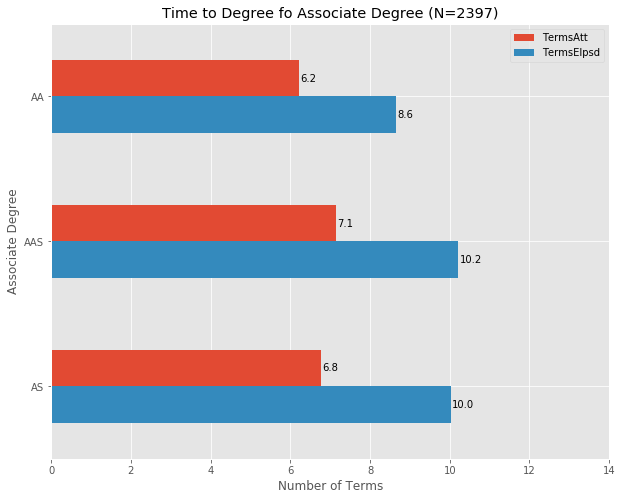

In [72]:
df = temp_sig[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").count())

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate Degree (N=2397)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.savefig("B.1.1.1.png", dpi=800, bbox="tight")
plt.show()

(1138, 3)


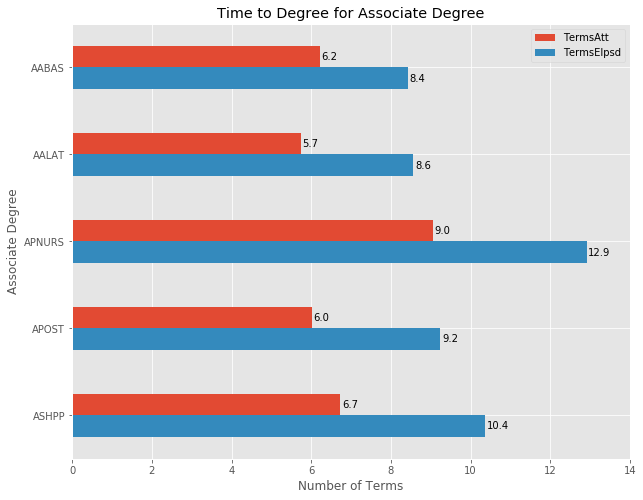

In [74]:
count_test = temp_sig[["TermsAtt", "TermsElpsd", "Prog"]].groupby('Prog').filter(lambda x: len(x) > 100)
df = count_test[["TermsAtt", "TermsElpsd", "Prog"]].groupby("Prog").mean()
print(count_test.shape)

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree for Associate Degree")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.savefig("B.1.1.2.png", dpi=800)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F        1293        1293
    M        1104        1104


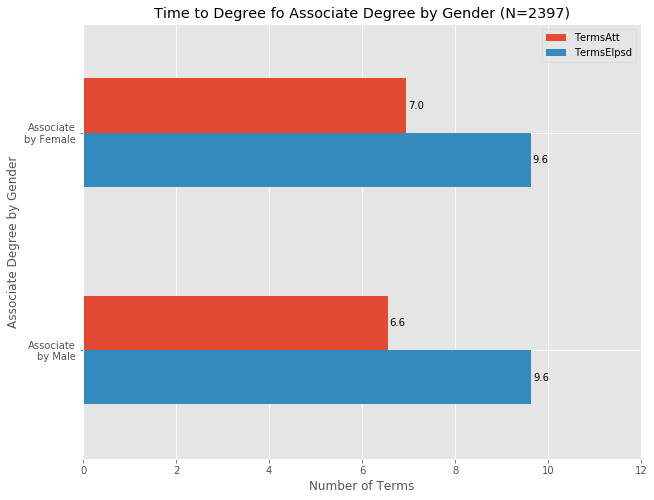

In [76]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 12) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender (N=2397)")
ax.set_yticklabels(["Associate\nby Female", "Associate\nby Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.savefig("B.1.1.3.png", dpi=800)
plt.show()

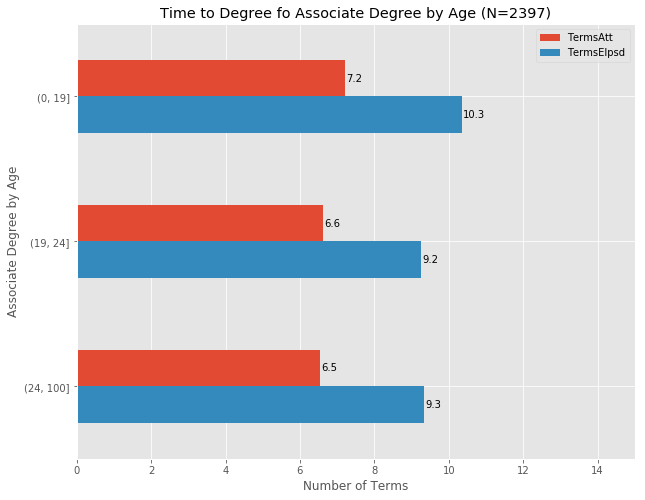

In [78]:
bins = [0, 19, 24, 100]
df = temp_sig[["TermsAtt", "TermsElpsd"]].groupby(pd.cut(temp_sig["Age"], bins=bins))

# df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean()
# print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean())

ax = df.mean().plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Age")
ax.set_title("Time to Degree fo Associate Degree by Age (N=2397)")
# ax.set_yticklabels(["Associate\nAge<=20", "Associate\nAge>20"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)    
plt.savefig("B.1.1.4.png", dpi=800, bbox="tight")
plt.show()


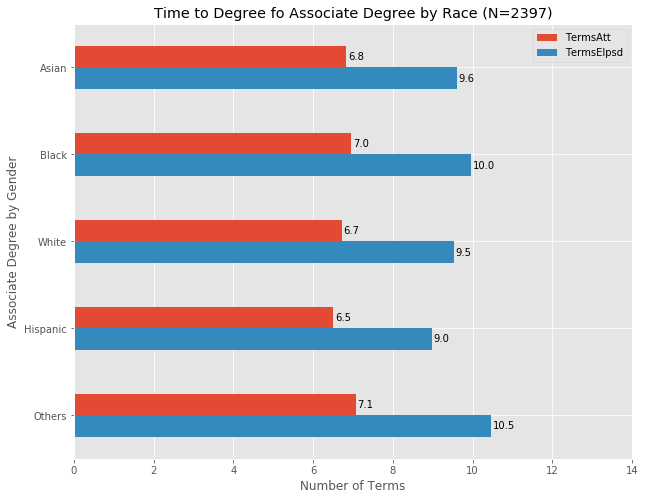

In [81]:
race_list = ['A', 'B', 'W', 'H']
temp_sig.loc[~temp_sig["Eth"].isin(race_list), "Eth"] = "Others" 
df = temp_sig[["TermsAtt", "TermsElpsd", "Eth"]].groupby(["Eth"]).mean().reset_index()

ax = df.set_index(['Eth']).reindex(['A', 'B', 'W', 'H', 'Others']).plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Race (N=2397)")
ax.set_yticklabels(["Asian", "Black", "White", "Hispanic", "Others"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.rcParams["figure.figsize"] = (10,8)
plt.savefig("B.1.1.5.png", dpi=800, bbox="tight")
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      5.552716
(10, 15]     8.531621
(15, 20]     9.657025
(20, 30]    10.535714


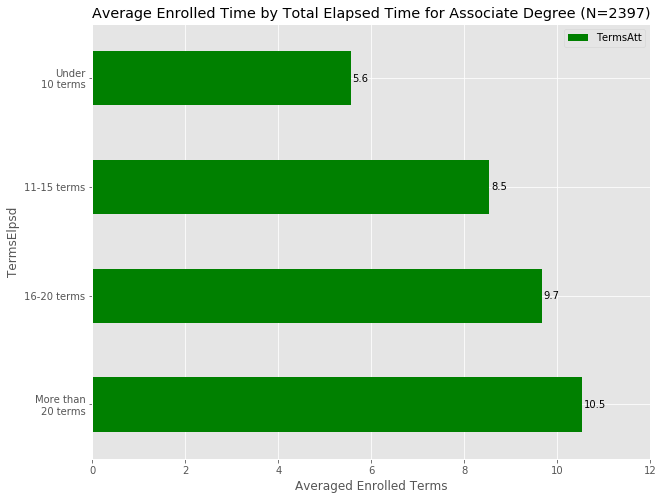

In [84]:
bins = [0, 10, 15, 20, 30]
df = temp_sig[["TermsAtt"]].groupby(pd.cut(temp_sig["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 12)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree (N=2397)")
# ytick
ax.set_yticklabels(["Under\n10 terms", "11-15 terms", "16-20 terms", "More than\n20 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.savefig("B.1.1.6.png", dpi=800, bbox="tight")
plt.show()


#### Statistical Table for Excess Credits

In [106]:
df = temp_sig.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
12,AALAT,60.000000,364
44,APOST,60.000000,257
0,AABAS,60.000000,220
42,APNURS,67.666667,184
64,ASHPP,60.000000,113


In [107]:
temp_sig = temp_sig[(~temp_sig["Prog"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["Prog"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["Prog"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog"], right_on = ["Prog"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(12)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
12,AALAT,364,328,90.11%
44,APOST,257,239,93.00%
0,AABAS,220,213,96.82%
42,APNURS,184,184,100.00%
64,ASHPP,113,107,94.69%
63,ASGSMS,91,84,92.31%
26,APCNSP,81,72,88.89%
34,APITRN,63,48,76.19%
9,AAHUST,60,60,100.00%
2,AACJ,53,53,100.00%


In [108]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["Prog", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr', 'CumCrTran']]
temp.columns = ["Prog", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max', 'CumCrTran']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max', 'CumCrTran':'mean'}
temp = temp.groupby(['Prog']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,CumCrTran
0,AABAS,60.0,73.0,73.990909,108.0,13.0,13.990909,48.0,22.940909
1,AABCA,61.0,76.5,76.500000,93.0,14.0,14.500000,29.0,11.833333
2,AACJ,63.0,88.0,87.452830,118.0,25.0,24.566038,55.0,24.641509
3,AACMG,66.0,80.0,86.111111,109.0,11.0,19.444444,43.0,21.333333
4,AADVP,62.0,77.5,81.770833,113.0,15.5,20.187500,51.0,21.375000


In [109]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog"], right_on = ["Prog"])

excessCredits_table['Percent of Prior Credits'] = excessCredits_table['CumCrTran']/excessCredits_table['CumCrErn_mean']
excessCredits_table['Percent of Prior Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in excessCredits_table['Percent of Prior Credits']], index = excessCredits_table.index)
del excessCredits_table['CumCrTran']

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,Percent of Prior Credits
12,AALAT,364,328,90.11%,60.0,68.0,70.685440,110.0,8.0,10.685440,50.0,31.09%
44,APOST,257,239,93.00%,60.0,69.5,73.780156,137.0,9.5,13.780156,77.0,37.94%
0,AABAS,220,213,96.82%,60.0,73.0,73.990909,108.0,13.0,13.990909,48.0,31.01%
42,APNURS,184,184,100.00%,72.0,100.0,102.342391,150.0,29.0,32.152174,78.0,28.28%
64,ASHPP,113,107,94.69%,60.0,71.0,73.345133,109.0,11.0,13.345133,49.0,32.00%
63,ASGSMS,91,84,92.31%,60.0,73.0,75.175824,144.5,13.0,15.175824,84.5,26.43%
26,APCNSP,81,72,88.89%,60.0,63.0,67.018519,91.0,3.0,7.018519,31.0,61.07%
34,APITRN,63,48,76.19%,60.0,63.0,66.706349,94.0,3.0,6.706349,34.0,67.92%
9,AAHUST,60,60,100.00%,61.0,83.0,84.800000,121.5,22.0,23.850000,60.5,24.15%
2,AACJ,53,53,100.00%,63.0,88.0,87.452830,118.0,25.0,24.566038,55.0,28.18%


In [0]:
record.to_excel("B.1.2.xlsx")

In [115]:
# Another table based on DegC
df = temp_sig.groupby(["DegC", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['DegC']).aggregate(aggregation_functions)

df = df.rename(columns={"DegC": "Degree", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,DegC,Required Credits,Num of Completers
1,AAS,57.722222,1243
0,AA,63.750000,839
2,AS,64.500000,315


In [116]:
temp_sig = temp_sig[(~temp_sig["DegC"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["DegC"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["DegC"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["DegC"], right_on = ["DegC"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
1,AAS,1243,1189,95.66%
0,AA,839,791,94.28%
2,AS,315,300,95.24%


In [118]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["DegC", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr','CumCrTran']]
temp.columns = ["DegC", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max', 'CumCrTran']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max', 'CumCrTran':'mean'}
temp = temp.groupby(['DegC']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,DegC,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,CumCrTran
0,AA,60.0,73.0,74.810489,129.0,12.0,14.249106,65.0,21.980930
1,AAS,61.0,80.0,82.687450,150.0,17.0,19.976267,84.0,27.550282
2,AS,60.0,74.5,77.079365,146.0,14.0,16.136508,84.5,22.542857


In [119]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["DegC"], right_on = ["DegC"])

excessCredits_table['Percent of Prior Credits'] = excessCredits_table['CumCrTran']/excessCredits_table['CumCrErn_mean']
excessCredits_table['Percent of Prior Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in excessCredits_table['Percent of Prior Credits']], index = excessCredits_table.index)
del excessCredits_table['CumCrTran']

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,Percent of Prior Credits
1,AAS,1243,1189,95.66%,61.0,80.0,82.687450,150.0,17.0,19.976267,84.0,33.32%
0,AA,839,791,94.28%,60.0,73.0,74.810489,129.0,12.0,14.249106,65.0,29.38%
2,AS,315,300,95.24%,60.0,74.5,77.079365,146.0,14.0,16.136508,84.5,29.25%


In [0]:
record.to_excel("B.1.2(Degree).xlsx")

### 5.2.2 More than one Associate degree

In [122]:
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] > 0]
temp_dup = temp[temp.duplicated(['PIDM'], keep=False)]
print(len(temp_dup['PIDM'].unique()))

temp_dup.head(10)

157


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,DegC,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC,ExcessCr
475,2019-09-09,844375,@00502733,A,35.0,36.0,F,W,201009,200909,4.0,4.0,2011.0,LAT,AALAT,AA,59.0,68.0,18.0,60.0,2011.0,50.0,8.0
787,2019-09-09,843359,@00501743,A,43.0,44.0,F,B,201101,200909,5.0,5.0,2011.0,OST,APOST,AAS,28.5,63.0,44.0,60.0,2011.0,19.0,3.0
807,2019-09-09,844375,@00502733,A,35.0,37.0,F,W,201101,200909,5.0,5.0,2011.0,SECO,AASECO,AA,72.0,81.0,18.0,60.0,2011.0,63.0,21.0
822,2019-09-09,847241,@00505572,A,43.0,45.0,F,H,201101,200909,5.0,5.0,2011.0,DVP,AADVP,AA,68.0,102.0,38.0,62.0,2011.0,64.0,40.0
823,2019-09-09,847241,@00505572,A,43.0,45.0,F,H,201101,200909,5.0,5.0,2011.0,LAT,AALAT,AA,68.0,102.0,38.0,60.0,2011.0,64.0,42.0
1281,2019-09-09,771217,@00414571,A,18.0,20.0,M,W,201109,200909,7.0,7.0,2012.0,HVCR,APHVCR,AAS,62.0,65.0,3.0,60.0,2012.0,62.0,5.0
1443,2019-09-09,846517,@00504869,A,25.0,27.0,M,I,201109,201001,6.0,6.0,2012.0,OST,APOST,AAS,85.0,122.0,45.0,60.0,2012.0,77.0,62.0
1480,2019-09-09,853855,@00511986,A,28.0,30.0,M,H,201109,201001,6.0,6.0,2012.0,LAT,AALAT,AA,46.0,90.5,45.0,60.0,2012.0,45.5,30.5
1481,2019-09-09,853855,@00511986,A,28.0,30.0,M,H,201109,201001,6.0,6.0,2012.0,OST,APOST,AAS,46.0,90.5,45.0,60.0,2012.0,45.5,30.5
1492,2019-09-09,855457,@00513503,A,47.0,48.0,M,W,201109,201009,4.0,4.0,2012.0,STH,APSTH,AAS,24.0,70.5,46.5,61.0,2012.0,24.0,9.5


#### Enrolled Term and Elapsed Term for Associate Degree

      TermsAtt  TermsElpsd
DegC                      
AA         107         107
AAS        167         167
AS          51          51


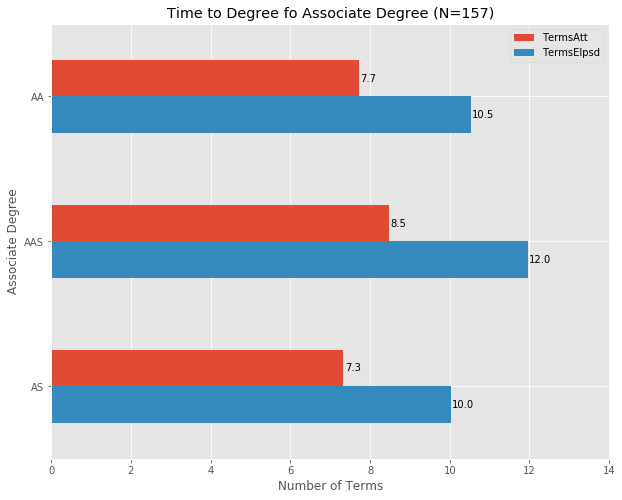

In [124]:
df = temp_dup[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "DegC"]].groupby("DegC").count())

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate Degree (N=157)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.savefig("B.2.1.1.png", dpi=800)
plt.show()

(4, 2)


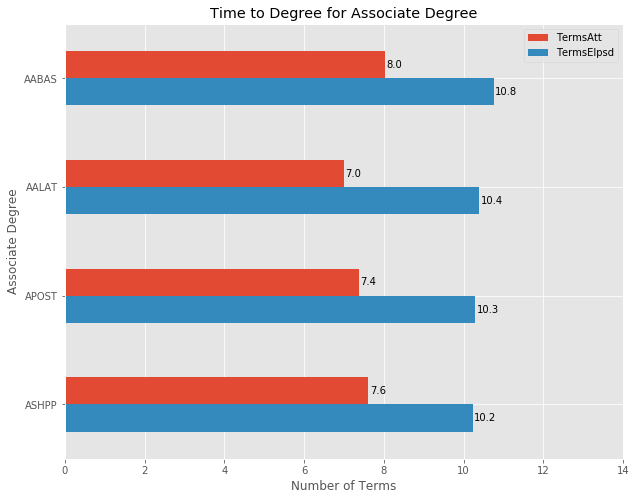

In [128]:
count_test = temp_dup[["TermsAtt", "TermsElpsd", "Prog"]].groupby('Prog').filter(lambda x: len(x) > 20)
df = count_test[["TermsAtt", "TermsElpsd", "Prog"]].groupby("Prog").mean()
print(df.shape)

# visualization
ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree for Associate Degree")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.savefig("B.2.1.2.png", dpi=800)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F         153         153
    M         172         172


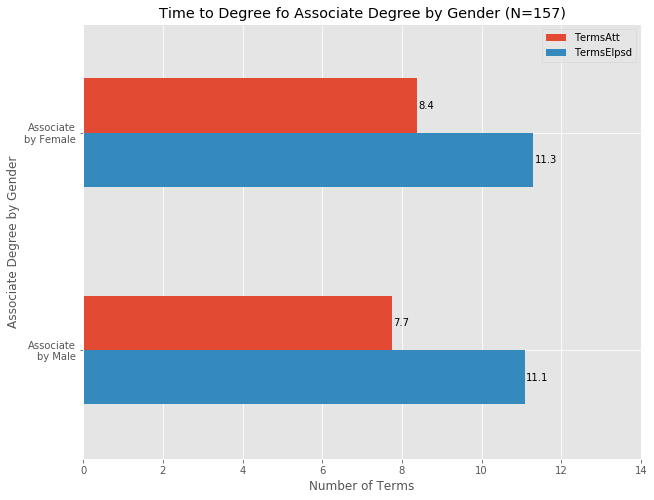

In [130]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 14) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender (N=157)")
ax.set_yticklabels(["Associate\nby Female", "Associate\nby Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)   
plt.savefig("B.2.1.3.png", dpi=800, bbox="tight")
plt.show()

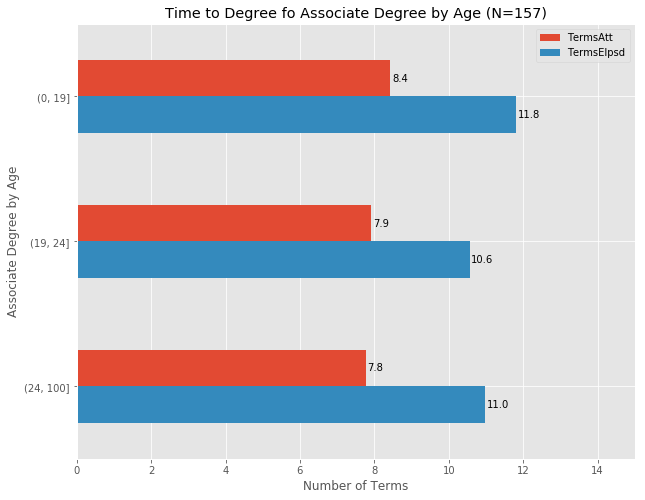

In [131]:
bins = [0, 19, 24, 100]
df = temp_dup[["TermsAtt", "TermsElpsd"]].groupby(pd.cut(temp_dup["Age"], bins=bins))

# df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean()
# print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean())

ax = df.mean().plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Age")
ax.set_title("Time to Degree fo Associate Degree by Age (N=157)")
# ax.set_yticklabels(["Associate\nAge<=20", "Associate\nAge>20"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)    
plt.savefig("B.2.1.4.png", dpi=800, bbox="tight")
plt.show()

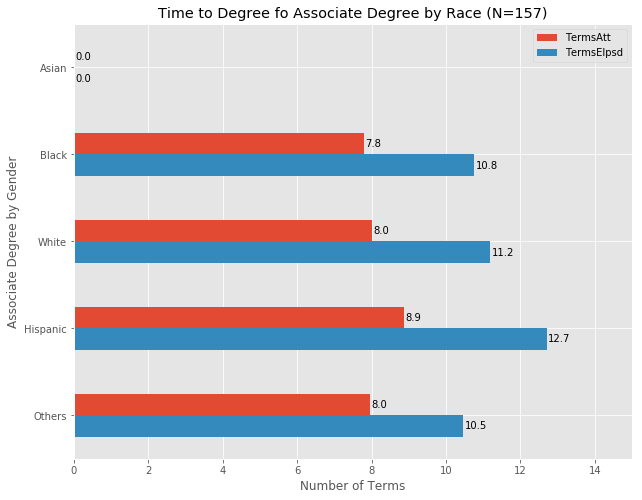

In [132]:
race_list = ['A', 'B', 'W', 'H']
temp_dup.loc[~temp_dup["Eth"].isin(race_list), "Eth"] = "Others" 
df = temp_dup[["TermsAtt", "TermsElpsd", "Eth"]].groupby(["Eth"]).mean().reset_index()

ax = df.set_index(['Eth']).reindex(['A', 'B', 'W', 'H', 'Others']).plot.barh()
ax.invert_yaxis()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 15) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Race (N=157)")
ax.set_yticklabels(["Asian", "Black", "White", "Hispanic", "Others"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha) 
plt.rcParams["figure.figsize"] = (10,8)
plt.savefig("B.2.1.5.png", dpi=800, bbox="tight")
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      6.134503
(10, 15]     9.310345
(15, 20]    10.456522
(20, 30]    13.000000


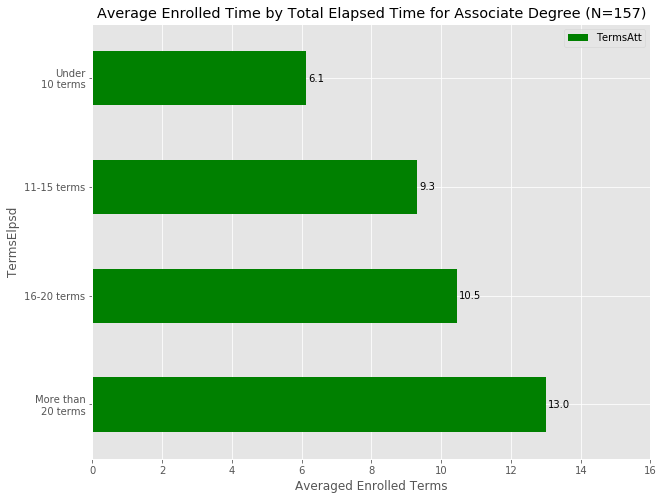

In [135]:
bins = [0, 10, 15, 20, 30]
df = temp_dup[["TermsAtt"]].groupby(pd.cut(temp_dup["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 16)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree (N=157)")
# ytick
ax.set_yticklabels(["Under\n10 terms", "11-15 terms", "16-20 terms", "More than\n20 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)
plt.savefig("B.2.1.6.png", dpi=800, bbox="tight")
plt.show()

#### Statistical Table for Excess Credits

In [136]:
df = temp_dup.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
40,APOST,60.0,59
12,AALAT,60.0,40
0,AABAS,60.0,37
55,ASHPP,60.0,26
54,ASGSMS,60.0,13


In [137]:
temp_dup = temp_dup[(~temp_dup["Prog"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["Prog"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["Prog"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog"], right_on = ["Prog"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
40,APOST,59,59,100.00%
12,AALAT,40,39,97.50%
0,AABAS,37,37,100.00%
55,ASHPP,26,24,92.31%
54,ASGSMS,13,13,100.00%


In [139]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["Prog", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr', 'CumCrTran']]
temp.columns = ["Prog", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max', 'CumCrTran']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max', 'CumCrTran': 'mean'}
temp = temp.groupby(['Prog']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,CumCrTran
0,AABAS,60.0,90.0,92.310811,132.5,30.0,32.310811,72.5,22.621622
1,AABCA,61.0,107.0,107.000000,107.0,46.0,46.000000,46.0,12.000000
2,AACJ,63.0,101.0,97.277778,106.0,35.0,33.944444,46.0,22.333333
3,AACMG,66.0,95.0,95.000000,95.0,29.0,29.000000,29.0,3.000000
4,AADVP,62.0,102.0,93.333333,116.0,40.0,31.333333,54.0,14.666667


In [140]:
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog"], right_on = ["Prog"])

excessCredits_table['Percent of Prior Credits'] = excessCredits_table['CumCrTran']/excessCredits_table['CumCrErn_mean']
excessCredits_table['Percent of Prior Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in excessCredits_table['Percent of Prior Credits']], index = excessCredits_table.index)
del excessCredits_table['CumCrTran']

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,Percent of Prior Credits
40,APOST,59,59,100.00%,60.0,86.00,89.440678,140.5,26.00,29.440678,80.5,28.84%
12,AALAT,40,39,97.50%,60.0,85.00,90.500000,164.5,25.00,30.500000,104.5,24.36%
0,AABAS,37,37,100.00%,60.0,90.00,92.310811,132.5,30.00,32.310811,72.5,24.51%
55,ASHPP,26,24,92.31%,60.0,80.00,80.557692,125.0,20.00,20.557692,65.0,19.72%
54,ASGSMS,13,13,100.00%,60.0,95.00,98.038462,150.0,35.00,38.038462,90.0,23.15%
38,APNURS,11,11,100.00%,72.0,118.00,120.727273,140.0,50.00,51.000000,69.0,12.27%
15,APACCT,11,11,100.00%,65.0,91.00,98.727273,125.0,26.00,33.727273,60.0,27.26%
2,AACJ,9,9,100.00%,63.0,101.00,97.277778,106.0,35.00,33.944444,46.0,22.96%
23,APCNSP,9,9,100.00%,60.0,84.00,83.833333,93.5,24.00,23.833333,33.5,57.79%
32,APITRN,8,8,100.00%,60.0,81.75,82.062500,96.5,21.75,22.062500,36.5,59.41%


In [0]:
record.to_excel("B.2.2.xlsx")

In [142]:
df = temp_dup.groupby(["DegC", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['DegC']).aggregate(aggregation_functions)

df = df.rename(columns={"DegC": "Degree", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,DegC,Required Credits,Num of Completers
1,AAS,66.000000,167
0,AA,62.666667,107
2,AS,62.000000,51


In [143]:
temp_dup = temp_dup[(~temp_dup["DegC"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["DegC"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["DegC"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["DegC"], right_on = ["DegC"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
1,AAS,167,167,100.00%
0,AA,107,104,97.20%
2,AS,51,49,96.08%


In [144]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["DegC", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr', 'CumCrTran']]
temp.columns = ["DegC", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max', 'CumCrTran']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max', 'CumCrTran':'mean'}
temp = temp.groupby(['DegC']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,DegC,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,CumCrTran
0,AA,60.0,91.0,91.962617,164.5,30.0,31.355140,104.5,21.813084
1,AAS,60.0,90.5,95.859281,195.0,29.0,33.631737,132.0,27.158683
2,AS,60.0,82.0,89.333333,150.0,22.0,28.941176,90.0,20.166667


In [145]:
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["DegC"], right_on = ["DegC"])

excessCredits_table['Percent of Prior Credits'] = excessCredits_table['CumCrTran']/excessCredits_table['CumCrErn_mean']
excessCredits_table['Percent of Prior Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in excessCredits_table['Percent of Prior Credits']], index = excessCredits_table.index)
del excessCredits_table['CumCrTran']

record = excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(30)
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,DegC,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max,Percent of Prior Credits
1,AAS,167,167,100.00%,60.0,90.5,95.859281,195.0,29.0,33.631737,132.0,28.33%
0,AA,107,104,97.20%,60.0,91.0,91.962617,164.5,30.0,31.355140,104.5,23.72%
2,AS,51,49,96.08%,60.0,82.0,89.333333,150.0,22.0,28.941176,90.0,22.57%


In [0]:
record.to_excel("B.2.2(Degree).xlsx")